In [441]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [442]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm

In [443]:
import bnn.data
import bnn.functions
import bnn.layer
import bnn.loss
import bnn.network
import bnn.optimizer

In [444]:
forward_func = bnn.functions.forward.SignBinarise()
#forward_func=bnn.functions.forward.LayerMeanBinarise()
#forward_func=bnn.functions.forward.LayerMedianBinarise()

In [445]:
#backward_func = bnn.functions.backward.SignTernarise()
#backward_func = bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=0.5)
backward_func = bnn.functions.backward.LayerQuantileTernarise(lo=0.25, hi=0.75)

In [446]:
INPUT_DIM = 8
OUTPUT_DIM = 8

In [447]:
dims = [INPUT_DIM, 100, 100, OUTPUT_DIM]
TBNN = bnn.network.TernBinNetwork(
    *dims,
    forward_func=forward_func,
    backward_func=backward_func,
)
TBNN._initialise(W_mean=0, W_zero_prob=0.5)

In [448]:
target_dims = [INPUT_DIM, 10, OUTPUT_DIM]
Target_TBNN = bnn.network.TernBinNetwork(
    *target_dims,
    forward_func=forward_func,
    backward_func=backward_func,
)
Target_TBNN._initialise(W_mean=0, W_zero_prob=0.8)

In [449]:
DL = bnn.data.target_network_factory(
    datapoints=1000,
    batch_size=1000,
    target_network=Target_TBNN,
    include_last_if_uneven=True,
)

In [450]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [451]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=0.001)

In [452]:
losses = []

In [453]:
train_epochs = 1000
num_logs = 10
epoch_log_rate = train_epochs // num_logs

In [454]:
for epoch in tqdm.trange(train_epochs):
    epoch_loss = 0
    for batch in DL:
        # forward pass and loss
        output = TBNN.forward(batch.input)
        loss = loss_func.forward(output=output, target=batch.target)

        # backward pass
        grad = loss_func.backward(output=output, target=batch.target)
        out_grad = TBNN.backward(grad)

        # optimizer step
        BernOpt.step(number_of_samples=len(input))

        # sum loss
        epoch_loss += loss

    # save loss
    losses.append(epoch_loss)

    early_exit = epoch_loss == 0
    if early_exit or (epoch % epoch_log_rate) == 0:
        print(f'epoch: {epoch}\tloss: {loss}')

    if early_exit:
        break

  0%|          | 0/1000 [00:00<?, ?it/s]


AttributeError: 'TargetNetwork' object has no attribute '_its'

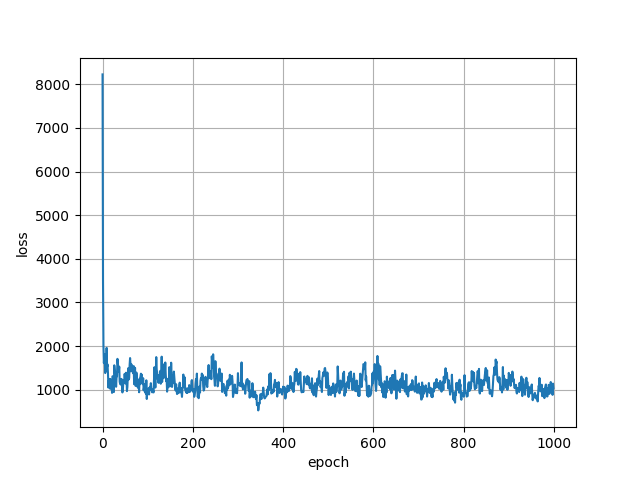

In [ ]:
NAME = 'loss_curve_partial'
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses[:train_epochs])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.show()

In [ ]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith('.w'):
        print(name, '\n', p, '\n', p.grad)

layers.TernBinLayer0.W 
 Parameter containing:
tensor([[-1, -1, -1,  0,  1,  1,  1,  0,  1,  0, -1,  1, -1,  1,  1, -1,  1,  1,
         -1,  1,  1, -1, -1,  1,  1,  1, -1, -1, -1,  1, -1,  1, -1, -1, -1,  0,
          0,  1,  1, -1,  0,  1,  1,  0,  0,  0,  1, -1,  1, -1, -1,  1,  0,  0,
          1, -1, -1, -1,  1,  1,  1, -1,  0, -1,  1, -1, -1,  0, -1,  1, -1, -1,
         -1, -1,  1,  0,  1, -1, -1, -1, -1, -1,  0,  1,  1,  1, -1, -1,  0,  1,
          0,  0,  1,  1,  0,  1, -1,  1, -1, -1],
        [-1,  1,  1, -1,  0, -1,  0,  0, -1,  0, -1,  0,  1, -1,  0,  0,  1, -1,
          1,  1,  1, -1, -1, -1,  0,  1, -1,  0, -1,  0,  1, -1,  1,  0,  0,  0,
          0,  0,  0,  1, -1, -1,  0, -1,  1, -1,  1, -1,  1, -1, -1,  0,  0,  0,
          1,  1, -1,  1, -1,  0, -1,  0,  1,  0,  1, -1, -1,  0,  0,  1,  0, -1,
          0, -1,  1,  0,  0,  1,  1, -1, -1,  0,  0,  1, -1,  0,  0, -1, -1, -1,
          0,  1, -1,  0,  0,  0,  0, -1,  0, -1],
        [ 0,  1, -1, -1,  1,  1, -1, -1,  0

In [ ]:
assert bnn.network.network_params_al_ternary(TBNN)